In [1]:
import pandas as pd
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline
color = sns.color_palette()
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score , recall_score, confusion_matrix
import os
os.listdir('/users/krutarthmajithia/downloads/HomeCredit')
sns.set_style('whitegrid')
pd.options.display.max_columns = 999
pd.options.display.max_info_rows = 125

/Users/krutarthmajithia/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('/users/krutarthmajithia/downloads/m_train_combined.csv')
test = pd.read_csv('/users/krutarthmajithia/downloads/m_test_combined.csv')

In [3]:
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_max           0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max     0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max      0.801178
dtype: float64

In [4]:
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_mean_max      0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_max       0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean      0.773223
dtype: float64

In [5]:
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


In [6]:
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 845)
Testing set full shape:  (48744, 845)


In [7]:
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [8]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782576
Early stopping, best iteration is:
[185]	valid_0's auc: 0.782763
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.783278
Early stopping, best iteration is:
[169]	valid_0's auc: 0.783628


In [9]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,153.0
25,EXT_SOURCE_2,143.0
26,EXT_SOURCE_3,137.0
368,client_installments_AMT_PAYMENT_min_sum,124.0
5,DAYS_BIRTH,105.5


In [10]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 274 features with 0.0 importance


,feature,importance
188,client_bureau_balance_STATUS_4_count_min,0.0
664,previous_loans_NAME_TYPE_SUITE_Other_A_count,0.0
187,client_bureau_balance_STATUS_4_count_max,0.0
186,client_bureau_balance_STATUS_4_count_mean,0.0
466,previous_loans_NAME_TYPE_SUITE_Children_count,0.0


In [11]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

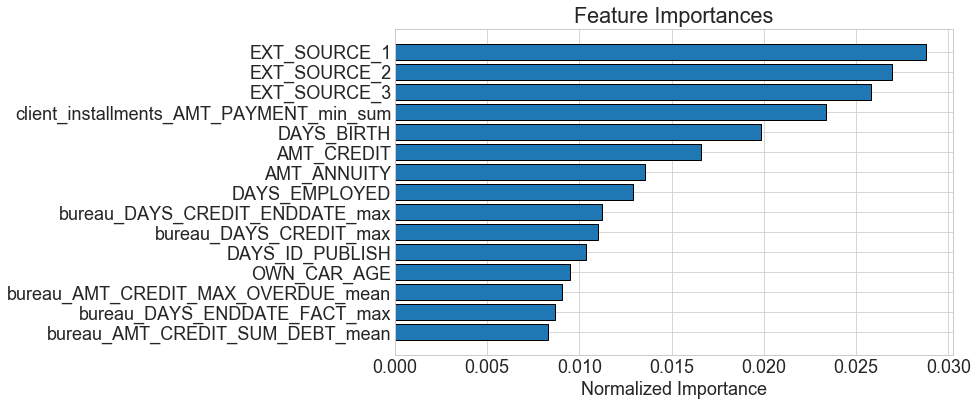

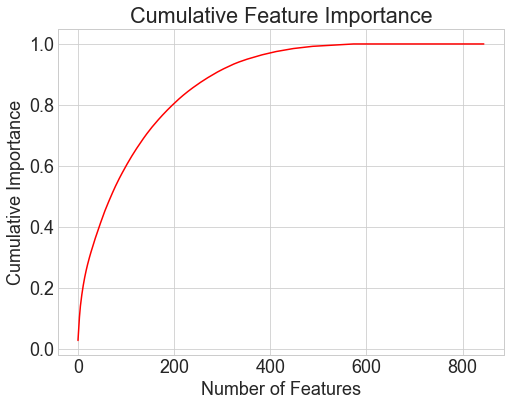

283 features required for 0.90 of cumulative importance


In [12]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [13]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 571)
Testing shape:  (48744, 571)


In [14]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [15]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782121
Early stopping, best iteration is:
[185]	valid_0's auc: 0.782763
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.783853
Early stopping, best iteration is:
[200]	valid_0's auc: 0.783853

There are 0 features with 0.0 importance


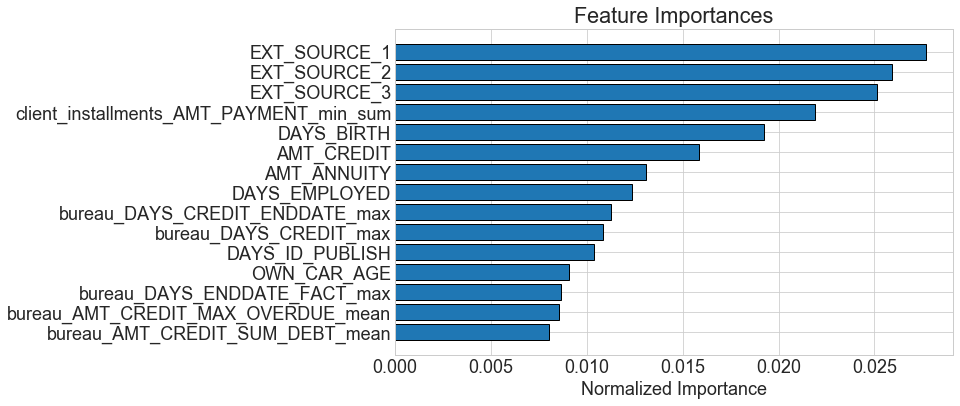

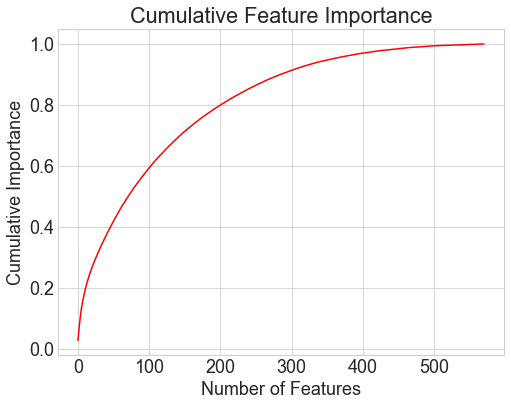

356 features required for 0.95 of cumulative importance


In [16]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [17]:
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [18]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score


In [19]:
N_FOLDS = 5
MAX_EVALS = 5

In [20]:
train['TARGET'] = train_labels

In [21]:
labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
features = train.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 10000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (297511, 570)
Test shape:  (10000, 570)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,client_bureau_balance_STATUS_1_count_sum,client_bureau_balance_STATUS_1_count_norm_mean,client_bureau_balance_STATUS_1_count_norm_max,client_bureau_balance_STATUS_1_count_norm_min,client_bureau_balance_STATUS_1_count_norm_sum,client_bureau_balance_STATUS_2_count_mean,client_bureau_balance_STATUS_2_count_norm_max,client_bureau_balance_STATUS_2_count_norm_min,client_bureau_balance_STATUS_2_count_norm_sum,client_bureau_balance_STATUS_3_count_mean,client_bureau_balance_STATUS_3_count_sum,client_bureau_balance_STATUS_3_count_norm_max,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_5_count_m

In [22]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [23]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

/Users/krutarthmajithia/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.77566 with std of 0.00313.
The ideal number of iterations was 184.


In [24]:
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.78250 ROC AUC on the test set.


In [25]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [26]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [27]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [28]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

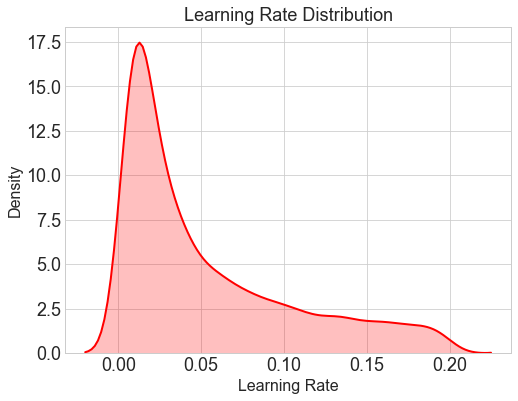

In [29]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);


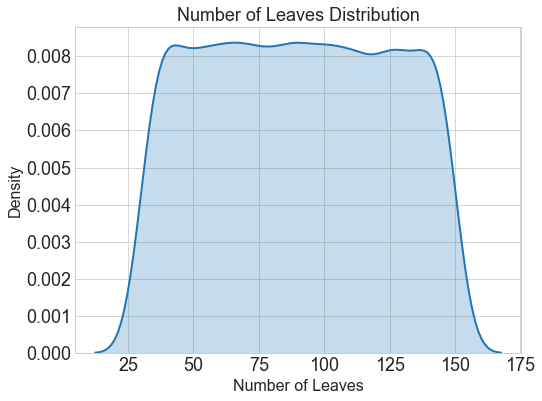

In [30]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [31]:
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.928660031441343}}

In [32]:
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

In [33]:
hyperparams

{'boosting_type': 'gbdt', 'subsample': 0.928660031441343}

In [34]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [35]:
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'dart',
 'colsample_bytree': 0.9926794114459593,
 'is_unbalance': False,
 'learning_rate': 0.4340473591053899,
 'min_child_samples': 255.0,
 'num_leaves': 96.0,
 'reg_alpha': 0.8618232012359963,
 'reg_lambda': 0.07267907004333729,
 'subsample': 0.6400191011469955,
 'subsample_for_bin': 20000.0}

In [36]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6130753110883368,
 'is_unbalance': True,
 'learning_rate': 0.22142837026731957,
 'min_child_samples': 305.0,
 'num_leaves': 49.0,
 'reg_alpha': 0.32250641697664695,
 'reg_lambda': 0.21698121247836177,
 'subsample': 0.7388156961233514,
 'subsample_for_bin': 200000.0}

In [37]:
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.22023.
The optimal number of estimators was 529.


In [38]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [39]:
from hyperopt import Trials

# Record results
trials = Trials()

In [40]:
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [41]:
from hyperopt import fmin

In [42]:
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

{'boosting_type': 0,
 'colsample_by_tree': 0.7640194156791923,
 'gdbt_subsample': 0.6662361725493,
 'is_unbalance': 1,
 'learning_rate': 0.07257666026646414,
 'min_child_samples': 330.0,
 'num_leaves': 24.0,
 'reg_alpha': 0.4919158024723823,
 'reg_lambda': 0.8627351984768395,
 'subsample_for_bin': 240000.0}

In [43]:
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.7640194156791923,
   'is_unbalance': False,
   'learning_rate': 0.07257666026646414,
   'metric': 'auc',
   'min_child_samples': 330,
   'n_estimators': 433,
   'num_leaves': 24,
   'reg_alpha': 0.4919158024723823,
   'reg_lambda': 0.8627351984768395,
   'subsample': 0.6662361725493,
   'subsample_for_bin': 240000,
   'verbose': 1},
  'iteration': 2,
  'loss': 0.2193565726588258,
  'status': 'ok',
  'train_time': 622.588316381909}]

In [44]:
results = pd.read_csv(OUT_FILE)

In [45]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [46]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results


The highest cross validation score from Bayesian was 0.78064 found on iteration 2.
ROC AUC from Bayesian on test data = 0.78746.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,metric,verbose,n_estimators,iteration,score
0,gbdt,0.764019,False,0.072577,330,24,0.491916,0.862735,240000,0.666236,auc,1,433,2,0.780643
1,gbdt,0.927085,False,0.092858,300,33,0.157583,0.511918,200000,0.766846,auc,1,191,1,0.779355
2,gbdt,0.772273,True,0.074028,115,108,0.240448,0.686661,40000,0.896601,auc,1,142,5,0.776809
3,goss,0.630471,True,0.051929,155,129,0.424689,0.129067,260000,1.000000,auc,1,51,3,0.770678
4,gbdt,0.610634,True,0.254211,460,43,0.402779,0.367678,260000,0.721553,auc,1,49,4,0.770386


In [47]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)


In [48]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))